In [1]:
#!/usr/bin/python
import warnings
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

warnings.simplefilter('ignore', FutureWarning)

/opt/conda/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
# fetch asset data
def getData(ticker, date_from, date_to):
    data = pdr.DataReader(ticker, 'yahoo', date_from, date_to)
    return data

# https://pandas-datareader.readthedocs.io/en/latest/remote_data.html
Y|AAPL|Apple Inc. - Common Stock|Q|Q|N|100|N|N||AAPL|N  
Y|AMZN|Amazon.com, Inc. - Common Stock|Q|Q|N|100|N|N||AMZN|N  
Y|CCEP|Coca-Cola European Partners plc Ordinary Shares|N| |N|100|N||CCEP|CCEP|N  
Y|FB|Facebook, Inc. - Class A Common Stock|Q|Q|N|100|N|N||FB|N  
Y|JNJ|Johnson & Johnson Common Stock|N| |N|100|N||JNJ|JNJ|N  
Y|JWN|Nordstrom, Inc. Common Stock|N| |N|100|N||JWN|JWN|N  
Y|NVS|Novartis AG Common Stock|N| |N|100|N||NVS|NVS|N  
Y|PG|Procter & Gamble Company (The) Common Stock|N| |N|100|N||PG|PG|N  

In [3]:
# obtain Apple Inc stock price data and drop Adj Close column
date_from = datetime.date(2020, 1, 1)
date_to = datetime.date(2020, 8, 31)
df = getData('AAPL', date_from, date_to)
df.drop('Adj Close', axis=1, inplace=True)
df.tail()

,High,Low,Open,Close,Volume
Date,,,,,
2020-08-25,125.180000,123.052498,124.697502,124.824997,211495600.0
2020-08-26,126.992500,125.082497,126.180000,126.522499,163022400.0
2020-08-27,127.485001,123.832497,127.142502,125.010002,155552400.0
2020-08-28,126.442497,124.577499,126.012497,124.807503,187630000.0
2020-08-31,131.000000,126.000000,127.580002,129.039993,225702700.0


In [4]:
def supres(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """
    from scipy.signal import savgol_filter as smooth

    # converting n to a nearest even number
    if n%2 != 0:
        n += 1
    
    n_ltp = ltp.shape[0] # length of ltp

    # smoothening the curve
    # scipy.signal.savgol_filter(x, window_length, polyorder, deriv=0, delta=1.0, axis=- 1, mode='interp', cval=0.0)
    # window_lengthint
    #   The length of the filter window (i.e., the number of coefficients).
    # polyorderint
    #   The order of the polynomial used to fit the samples.
    ltp_s = smooth(ltp, (n+1), 3) # the polynomial is 3 in this sample
    print('length of ltp_s: {}'.format(len(ltp_s)))

    # taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])
    print('length of ltp_d: {}'.format(len(ltp_d)))
 
    resistance = []
    support = []
    
    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i+n)]
        first = arr_sl[:int((n/2))] # first half
        last = arr_sl[int((n/2)):] # second half
        
        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        # local maxima detection
        if (r_1 == (n/2)) and (r_2 == (n/2)): 
            resistance.append(ltp[i+(int(n/2)-1)])

        # local minima detection
        if (s_1 == (n/2)) and (s_2 == (n/2)): 
            support.append(ltp[i+(int(n/2)-1)])

    return support, resistance

In [5]:
support, resistence = supres(df['Close'].to_numpy(), 30) # n is the number of entries to be scanned.

length of ltp_s: 168
length of ltp_d: 168


In [6]:
print(support)

[61.380001068115234]


In [7]:
print(resistence)

[81.30249786376953]


In [8]:
def supres_plot(df, support, resistence):
    
    for i in range(len(support)):
        print('Support line {0} is {1}'.format(i, support[i]))
        
    for i in range(len(resistence)):
        print('Resistence line {0} is {1}'.format(i, resistence[i]))
    
    fig, ax1 = plt.subplots(figsize=(15,10))
    
    color = 'tab:green'
    xdate = [x.date() for x in df.index]
    ax1.plot(xdate, df['Close'], label='close', color=color)
    ax1.plot(xdate, df['High'], label='high')
    ax1.plot(xdate, df['Low'], label='low')
    for sup in support:
        ax1.axhline(y=sup, linewidth='1.0', color='red')
    for res in resistence:
        ax1.axhline(y=res, linewidth='1.0', color='blue')
    ax1.legend()
    ax1.set_title(label='Support and resistence lines')
    plt.grid()
    plt.show()

Support line 0 is 61.380001068115234
Resistence line 0 is 81.30249786376953


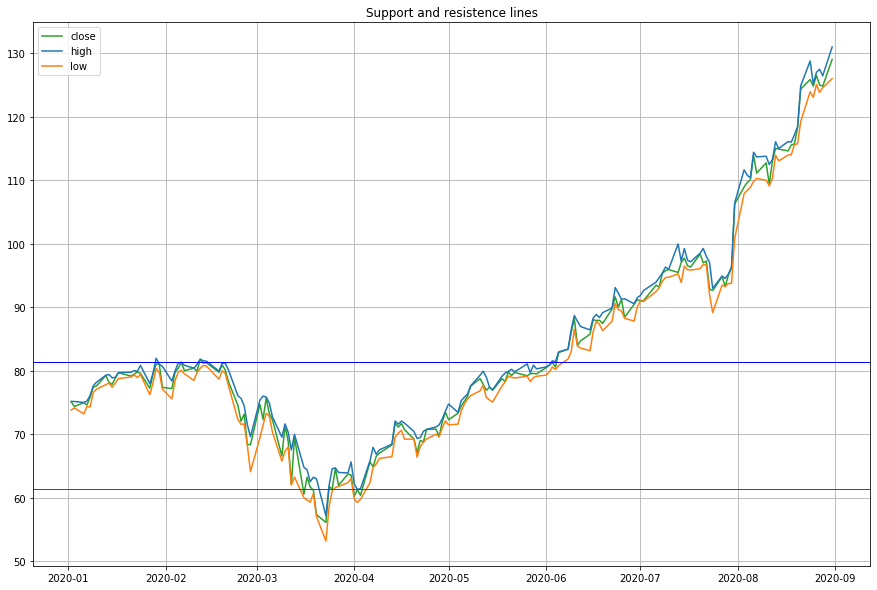

In [9]:
supres_plot(df, support, resistence)